### Libraries

In [1]:
#Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

### Function and class definitions

In [2]:
#Shuffles the whole data
def shuffle_array(arr):
    np.random.seed(1337)
    l = len(arr)
    for i in range(0,l):
        index = np.random.randint(0, l)
        arr[i] = arr[index]
        
#Normalization by using numpy's max and min functions
#Returns records with normalized values
def min_max_normalization(X_data):
    max_element_column = X_data.max(axis = 0) #Finding maximum elements for each column
    min_element_column = X_data.min(axis = 0) #Finding minimum elements for each column
    return (X_data - min_element_column)/(max_element_column - min_element_column)

#Splits train and test data
#k_fold parameter is there for k_fold cross validation, set default = -1 showing that it is not active
#percentage is there for percentage of the test data over whole data, set default = -1 showing that it is not active
#Return type: X_train, y_train, X_test, y_test
def split_train_test(arr, dropCols, regCol, k_fold = -1, percentage = -1, index = 0):
    if (k_fold != -1): test_size = int(len(arr) / k_fold)
    else: test_size = int(len(arr) / 100 * percentage)
    test_array = arr[test_size * index: test_size * (index + 1)]
    train_array = np.delete(arr, slice(test_size * index, test_size * (index + 1)), 0)
    #X_train = train_array[:, 0:classIndex]
    X_train = np.delete(train_array, dropCols, axis = 1)
    y_train = train_array[:, [regCol]]
    X_test = np.delete(test_array, dropCols, axis = 1)
    y_test = test_array[:, [regCol]]
    return X_train, y_train, X_test, y_test

#Returns euclidean distance between two records and class type within a tuple
def calculate_euclidean_distance(X_test_instance, X_train_instance, y_train_instance):
    distance = np.sqrt(np.sum((X_test_instance - X_train_instance)**2))
    theVal = y_train_instance[0]
    return [distance, theVal]

#Returns closest points to the specified test instance from train data set
def find_closest_points(X_test_instance, X_train, y_train):
    distances = []
    for i in range(len(X_train)):
        distances.append(
            calculate_euclidean_distance(
                X_test_instance, X_train[i], y_train[i]))
    distances.sort()
    return distances

#Returns an estimation for the test instance over the train set
def estimate(X_test_instance, X_train, y_train, k, weighted):
    distance_pairs = find_closest_points(X_test_instance, X_train, y_train)[:k]
    total_w, total, weights = 0, 0, 0
    
    for pair in distance_pairs:
        w = 1 / (pair[0] + 0.0001)
        weights += w
        total += pair[1]
        total_w += pair[1]*w
    
    if (weighted == True): return total_w/weights
    else: return total / k

#Plots MSA values with the k values
def plot_MSA(MSAs, k):
    k_lst = ["{}".format(i) for i in range(1,k+1)]
    x = k_lst
    y = MSAs
    plt.plot(x, y)
    plt.xlabel("k Values", labelpad=7)
    plt.ylabel("MSA", labelpad=7)
    
#Plots MSA values with the k values
def plot_folds(MSAs, fold_num):
    fold_lst = ["{}".format(i) for i in range(1, fold_num+1)]
    x = fold_lst
    y = MSAs
    plt.plot(x, y)
    plt.xlabel("Fold Number", labelpad=7)
    plt.ylabel("MSA", labelpad=7)

class kNN:
    
    def __init__(self, X_train, y_train, X_test, y_test, k, weighted, normalized):
        
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.k = k
        self.weighted = weighted              
        self.normalized = normalized
        self.MAE = 0
        self.predictions = list() 
        
        #normalize the array
        if (normalized):
            self.X_train = min_max_normalization(self.X_train)
            self.X_test = min_max_normalization(self.X_test)
        
        #estimation part
        for i in range(len(self.X_test)):
            predicted_value = estimate(self.X_test[i], self.X_train, self.y_train, self.k, self.weighted)
            self.predictions.append(predicted_value)
            actual_value = self.y_test[i][0]
            self.MAE += abs(predicted_value - actual_value)
        
        self.predictions = np.array(self.predictions)
        self.MAE = self.MAE / len(self.X_test)
        
    def get_predictions(self):
        return self.predictions
    
    def get_MAE(self):
        return self.MAE
    

### Tuning parameters

In [3]:
regCol = 8 #Index of the column will be used by classifying
dropCol = [8, 9]
percentageVal = 25 #Percentage of test data out of all data
k_val = 20 #K value
index, k_fold = 0, 10 #K-fold parameters

### Preparing the data 

In [4]:
#Data to dataframe
df = pd.read_csv('energy_efficiency_data.csv')
arr = df.to_numpy()
shuffle_array(arr)
X_train, y_train, X_test, y_test = split_train_test(arr, dropCol, regCol, percentage = percentageVal)

### Reports

**Plotting MSA errors with the given k values over the train dataset.**<br>
*4 different situations have been overviewed.*

*NOT WEIGHTED & NOT NORMALIZED*

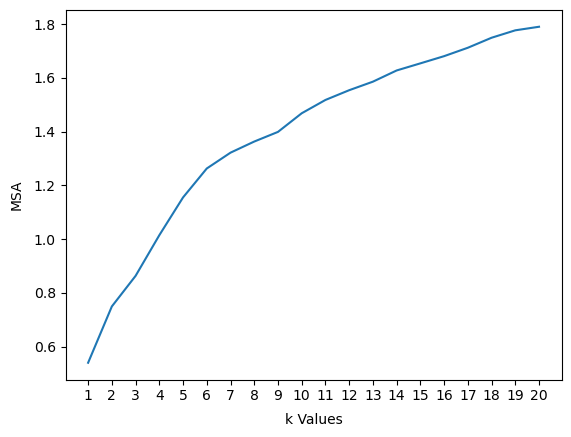

In [5]:
MSAs = list()
for k in range(1,k_val+1):
    model = kNN(X_train, y_train, X_test, y_test, k, False, False)
    MSAs.append(model.get_MAE())
plot_MSA(MSAs, k_val)

*WEIGHTED & NOT NORMALIZED*

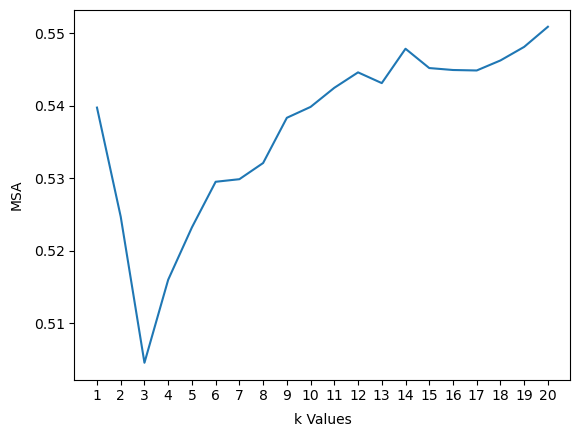

In [6]:
MSAs = list()
for k in range(1,k_val+1):
    model = kNN(X_train, y_train, X_test, y_test, k, True, False)
    MSAs.append(model.get_MAE())
plot_MSA(MSAs, k_val)

*NOT WEIGHTED & NORMALIZED*

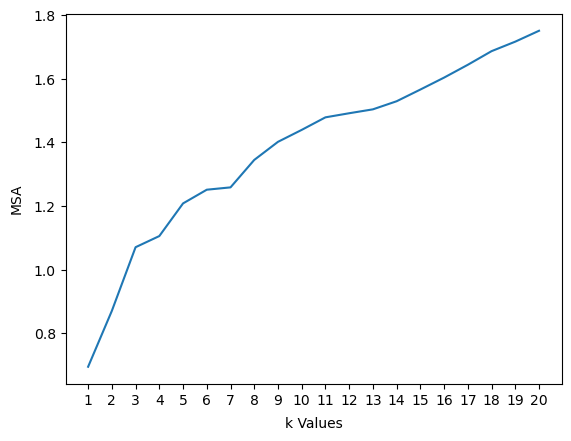

In [7]:
MSAs = list()
for k in range(1,k_val+1):
    model = kNN(X_train, y_train, X_test, y_test, k, False, True)
    MSAs.append(model.get_MAE())
plot_MSA(MSAs, k_val)

*WEIGHTED & NORMALIZED*

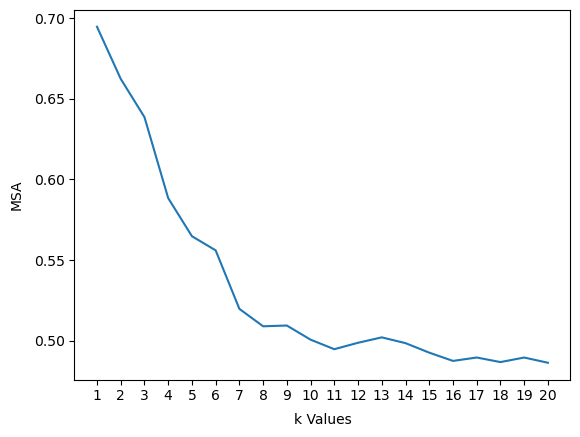

In [8]:
MSAs = list()
for k in range(1,k_val+1):
    model = kNN(X_train, y_train, X_test, y_test, k, True, True)
    MSAs.append(model.get_MAE())
plot_MSA(MSAs, k_val)

**k-fold Cross Validation**

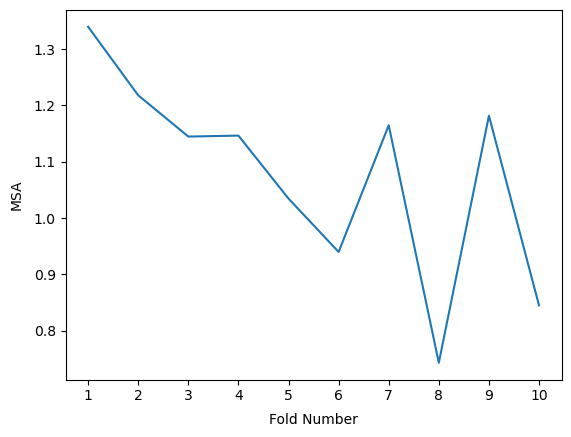

In [9]:
folds = list()
k_val = 9
for i in range(k_fold):
    index = i
    X_train, y_train, X_test, y_test = split_train_test(arr, dropCol, regCol, k_fold = k_fold, index = index)
    model = kNN(X_train, y_train, X_test, y_test, k_val, False, False)
    folds.append(model.get_MAE())
plot_folds(folds, k_fold)